In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()

In [2]:
#%load_ext vimception

In [2]:
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import pandas as pd
import numpy as np
import netCDF4
from matplotlib.ticker import MultipleLocator
from scipy.interpolate import *

In [3]:
filename='/Users/ptg21/data/projects/Blowsea/ancil_creation/ACTM_T42L67_GeoPotHgt_regrid_N48.nc'
ncfilea     = netCDF4.Dataset(filename)
lona        = ncfilea.variables['longitude'][:]
lata        = ncfilea.variables['latitude'][:] 
timesa      = ncfilea.variables['time']
GeoPH       = ncfilea.variables['Z'][:,:,:,:]
nmonthsa, nlevelsa, nya, nxa = np.shape(GeoPH)


In [4]:
filename='/Users/ptg21/data/projects/Blowsea/ancil_creation/ACTM_T42L67_OH_N48_regrid.nc'
ncfile1    = netCDF4.Dataset(filename)
lon1        = ncfile1.variables['longitude'][:]
lat1        = ncfile1.variables['latitude'][:] 
level1      = ncfile1.variables['level'][:] # sigma
times1      = ncfile1.variables['time']
OHfield     = ncfile1.variables['NDOH'][:,:,:,:]
nmonths, nlevels, ny1, nx1 = np.shape(OHfield)
nboundaries = nlevels + 1
nx1 = len(lon1)
ny1 = len(lat1)

In [5]:
filename='/Users/ptg21/data/projects/Blowsea/ancil_creation/ACTM_T42L67_Ps_N48_regrid.nc'
ncfile2     = netCDF4.Dataset(filename)
lon2        = ncfile2.variables['longitude'][:]
lat2        = ncfile2.variables['latitude'][:] 
times2      = ncfile2.variables['time']
PS          = ncfile2.variables['PS'][:,:,:]
nmonths, ny2, nx2 = np.shape(PS)

nx2 = len(lon2)
ny2 = len(lat2)

In [6]:
# get file containing heights, pressures for L85 ancil
filename='/Users/ptg21/data/projects/Blowsea/ancil_creation/xjcira.p.nc'
ncfile3     = netCDF4.Dataset(filename)

lon3        = ncfile3.variables['longitude'][:]
lat3        = ncfile3.variables['latitude'][:]
press       = ncfile3.variables['p'][:]
hybrid_ht   = ncfile3.variables['hybrid_ht'][:]
times3      = ncfile3.variables['t']
nmonths3, nheights3, ny3, nx3 = np.shape(press)


In [7]:
# plt.figure(1)
# plt.subplot(1,2,1)
# plt.plot(new_press[0,:,0,-1]*100.,'o', label=str(lon2[0])+', '+str(lat2[-1]))
# plt.legend()
# plt.subplot(1,2,2)
# plt.plot(press[0,:,0,0],label=str(lon3[0])+', '+str(lat3[0]))
# plt.legend()

In [8]:
filename='/Users/ptg21/data/projects/Blowsea/ancil_creation/oh_concentration_trop_N48_regrid.nc'
ncfile4    = netCDF4.Dataset(filename)
lon4        = ncfile4.variables['longitude'][:]
lat4        = ncfile4.variables['latitude'][:]
level4      = ncfile4.variables['LEVEL'][:]
times4      = ncfile4.variables['TIME']
OHfield     = ncfile4.variables['OH'][:,:,:,:]
nmonth4, nlevel4, ny4, nx4 = np.shape(OHfield)


# get levelp1, a, b variables for use in calc of level boundary pressures
filename='/Users/ptg21/data/projects/TRANSCOM/ancil_creation/oh/oh_concentration_trop.nc'
ncfile5    = netCDF4.Dataset(filename)
levelp1    = ncfile5.variables['LEVELP1'][:]
avar       = ncfile5.variables['A'][:]
bvar       = ncfile5.variables['B'][:]
lon5        = ncfile5.variables['LONGITUDE'][:]
lat5        = ncfile5.variables['LATITUDE'][:]
level5      = ncfile5.variables['LEVEL'][:]
nboundaries = len(levelp1)
# get psurf needed for same
filename='/Users/ptg21/data/projects/Blowsea/ancil_creation/oh_concentration_trop_psurf_N48_regrid.nc'
ncfile6    = netCDF4.Dataset(filename)
lon6        = ncfile6.variables['longitude'][:]
lat6        = ncfile6.variables['latitude'][:]
psurf       = ncfile6.variables['PSURF'][:]
ntimes6, ny6, nx6   = np.shape(psurf)



In [9]:
# test for matching heights or pressures

ilat = 0
ilon = 0
imonth = 0
pnew = press[imonth, :, ilat, ilon]
pold = np.empty_like(level5)
#pold = level1[:]*PS[itime,ilon,ilat] * 100. # use this for sigma levels
for levvar in range(0, nboundaries-1):
    plowerbound = avar[levvar]+bvar[levvar]*psurf[imonth,ilat,ilon] 
    pupperbound = avar[levvar+1]+bvar[levvar+1]*psurf[imonth,ilat,ilon]
    midpt_press = 0.5*(plowerbound + pupperbound)
    pold[levvar] = midpt_press
#print (pold, pnew)


In [10]:
pressure_in = np.empty_like(OHfield)
for imonth in range (0, nmonths3):
    for ilat in range(0, ny3):
        for ilon in range (0, nx3):
            # pressure levels on which to interpolate
            pnew = press[imonth, :, ilat, ilon]
            # dummy array to store the pressure levels of the data
            pold = np.empty_like(level5)
            # array for interpolated data
            
            # calculate midpt pressures of hybrid sigma levels
            for levvar in range(0, nboundaries-1):
                plowerbound = avar[levvar]+bvar[levvar]*psurf[imonth,ilat,ilon] 
                pupperbound = avar[levvar+1]+bvar[levvar+1]*psurf[imonth,ilat,ilon]
                midpt_press = 0.5*(plowerbound + pupperbound)
                pold[levvar] = midpt_press
            pressure_in[imonth,:,ilat,ilon] = pold

In [11]:
err_str=''
OHres=np.zeros_like(press)
OHres_ht=np.zeros_like(press)
nmonths3, nheights3, ny3, nx3 = np.shape(press)


for imonth in range (0, nmonths3):
    print imonth
    for ilat in range(0, ny3):
        for ilon in range (0, nx3):
            # pressure levels on which to interpolate
            pnew = press[imonth, :, ilat, ilon]
            # dummy array to store the pressure levels of the data
            pold = np.empty_like(level5)
            # data for interpolation
            vals = OHfield[imonth, :, ilat, ilon]
            # array for interpolated data
            res = np.zeros_like(pnew)

            # calculate midpt pressures of hybrid sigma levels
            for levvar in range(0, nboundaries-1):
                plowerbound = avar[levvar]+bvar[levvar]*psurf[imonth,ilat,ilon] 
                pupperbound = avar[levvar+1]+bvar[levvar+1]*psurf[imonth,ilat,ilon]
                midpt_press = 0.5*(plowerbound + pupperbound)
                pold[levvar] = midpt_press

            # for each new level, find corresponding pressure levels and interpolate OH concentration
            # need to check the case that there are two levels between the old levels.  think i did this!
            for newlev in range(0, len(pnew)):
                found = False
                for oldlev in range(0, len(pold)-1):
                    if pnew[newlev] < pold[oldlev] and pnew[newlev] >= pold[oldlev+1]:
                        grad = (vals[oldlev]-vals[oldlev+1])/(pold[oldlev]- pold[oldlev+1])
                        val_at_newlev=vals[oldlev]+grad*(pnew[newlev]-pold[oldlev])            
                        #print str(pnew[newlev])+ 'Pa  lies between '+ str(pold[oldlev])+' and ' +str(pold[oldlev+1])+ ' Pa and corresponds to a height of ' + str(hybrid_ht[newlev]) +' m'#+ ' extrapolated value', val_at_newlev
                        #print 'OH conc at this point', val_at_newlev/1e6,'between', vals[oldlev]/1e6, ' and ', vals[oldlev+1]/1e6, '\n'
                        res[newlev] = val_at_newlev
                        found = True
                
                    if found == False:
                        if pnew[newlev] > pold.max():
                            # the pressure of the new level is too low, ie ie at the bottom of the atm
                            #print "high, level = ", newlev, pnew[newlev], pold.max(), vals[-1]
                            res[newlev] = vals[0]
                            found = True
                        elif pnew[newlev] < pold.min():
                            # the pressure of the new level is too low, ie at the top of the atm where photolysis is low
                            #print "low", newlev, pnew[newlev], pold.min(), vals[-1]
                            res[newlev]  = vals[-1]
                            found = True
                            #res[newlev] = vals[0]
                            #err_str = err_str+"\nrequired pressure not found" +str(pnew[newlev]) +'max of old pressures'+str( pold.max()) + '\n'
            # add the results to the output array
            OHres[imonth, :, ilat, ilon] = res
            OHres_ht[imonth, :, ilat, ilon] = res

0
1
2
3
4
5
6
7
8
9
10
11


In [12]:
np.save('interp_OH.npy',OHres_ht)
interp_OH=np.load('interp_OH.npy')

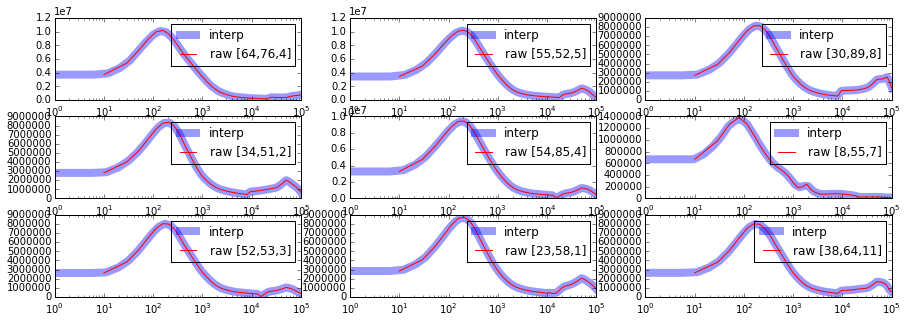

In [15]:
%matplotlib inline
from random import randint

plt.figure(figsize=(15,5))

for ivar in range (1,10):
    plt.subplot(3,3,ivar)
    month=randint(0,nmonths3-1)
    lat=randint(0,ny3-1)
    lon=randint(0,nx3-1)
    plt.semilogx(press[month,:,lat,lon],interp_OH[month,:,lat,lon], lw=8, alpha=0.4, label='interp')
    plt.semilogx(pressure_in[month,:,lat,lon],OHfield[month,:,lat,lon],'r-', label='raw [' + str(lat)+","+str(lon)+","+str(month)+"]")
    plt.xlim([1,1e5])
    plt.legend()

In [110]:
%%bash
rm -Rf N48_L60_OH.nc

In [16]:
from netCDF4 import Dataset
import time
# Create HDF5 *format*, classic *model*
dataset = Dataset('N48_L60_OH.nc', 'w', format='NETCDF4')

# Global Attributes
dataset.description = 'TEST NETCDF-CF COMPLIANT SCRIPT'
dataset.history = 'Created ' + time.ctime(time.time())
dataset.source = ''
dataset.Conventions = 'CF-1.0'
dataset.standard_name_vocabulary='CF-1.0'

height = dataset.createDimension('hybrid_ht', nheights3)
height     = dataset.createVariable('hybrid_ht',    np.int32,   ('hybrid_ht',))

time  = dataset.createDimension('time',      None)
time  = dataset.createVariable('time',       'f8', ('time',)) # or can use np as below

lat   = dataset.createDimension('latitude',  ny3)
lat   = dataset.createVariable('latitude',   np.float32, ('latitude',))

lon   = dataset.createDimension('longitude', nx3)
lon   = dataset.createVariable('longitude',  np.float32, ('longitude',))

OH         = dataset.createVariable('oh', np.float32, ('time','hybrid_ht','latitude', 'longitude',))

lon[:]   = lon3[:]
lat[:]   = lat3[:]
height[:] = hybrid_ht[:]
time[:]  = times3[:]

OH[:,:,:,:] = OHres[:,:,:,:]

# Variable Attributes
lat.standard_name = 'latitude'
lat.units = 'degrees_north'
lat.cartesian_axis = "Y"
lat.axis = 'Y'
lat.actual_range = -90.0, 90.0

lon.standard_name = 'longitude'
lon.units = 'degrees_east'
lon.cartesian_axis = "X"
lon.axis = "X"
lat.actual_range = 0.0, 360.0

OH.units = 'molecules / cm-3'
OH.standard_name='OH_mixing_ratio'

height.units = 'm'
height.axis='Z'
height.positive='up'
height.standard_name = 'hybrid_pressure_levels'


time.standard_name = 'time'
time.long_name = 'time'
time.units = 'days since 1999-12-01 00:00:00'
time.calendar = '360_day'
time.axis = 'T'
print ('success')
dataset.close()

success


<matplotlib.colorbar.Colorbar instance at 0x116767fc8>

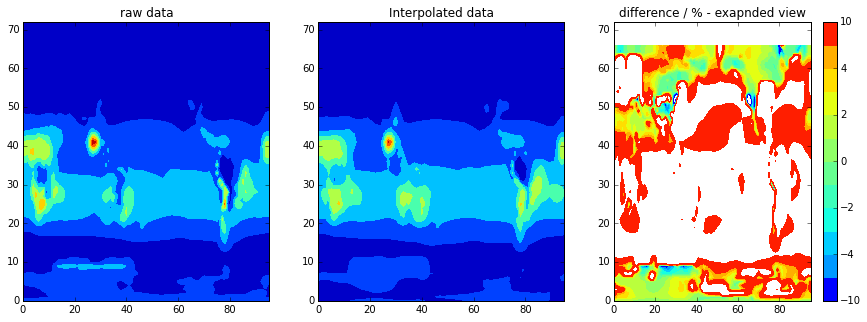

In [17]:
lev=7
plt.figure(figsize=(15,5))
plt.subplot(1,3,2)
plt.title('Interpolated data')
plt.contourf(OHres[0,lev,:,:])
plt.subplot(1,3,1)
plt.title('raw data')
plt.contourf(OHfield[0,lev,:,:])
plt.subplot(1,3,3)
plt.title('difference / % - exapnded view ')
plt.contourf((OHres[0,lev,:,:]-OHfield[0,lev,:,:])/(OHres[0,lev,:,:]+OHfield[0,lev,:,:])*100.,[-10,-5,-4,-3,-2,-1,0.,1,2,3,4,5,10])
plt.colorbar()


In [ ]:
diff_array=OHres[0,lev,:,:]-OHfield[0,lev,:,:]
indices = np.where( diff_array == diff_array.argmax() )

x_y_coords =  zip(indices[0], indices[1])
    

In [ ]:
vals = np.array([10.,  9.0, 8.5,  8.0, 7.0])
pnew = np.array([95., 91., 85., 83. ,82.0,81.0, 80.])

for newlev in range(0, len(pnew)-1):
    for oldlev in range(0, len(pold)):
        if pnew[newlev] < pold[oldlev] and pnew[newlev] >= pold[oldlev+1]:
            grad = (vals[oldlev]-vals[oldlev+1])/(pold[oldlev]- pold[oldlev+1])
            val_at_newlev=vals[oldlev]+grad*(pnew[newlev]-pold[oldlev])            
            print str(pnew[newlev])+ ' lies between '+ str(pold[oldlev])+' and ' +str(pold[oldlev+1]) #+ ' extrapolated value', val_at_newlev


In [ ]:
# test for matching heights or pressures
pold = np.array([100., 90., 85.0, 80., 70.])
vals = np.array([10.,  9.0, 8.5,  8.0, 7.0])
pnew = np.array([95., 91., 85., 83. ,82.0,81.0, 80.])

for newlev in range(0, len(pnew)):
    for oldlev in range(0, len(pold)-1):
        if pnew[newlev] < pold[oldlev] and pnew[newlev] >= pold[oldlev+1]:
            grad = (vals[oldlev]-vals[oldlev+1])/(pold[oldlev]- pold[oldlev+1])
            val_at_newlev=vals[oldlev]+grad*(pnew[newlev]-pold[oldlev])            
            print str(pnew[newlev])+ ' lies between '+ str(pold[oldlev])+' and ' +str(pold[oldlev+1]) + ' extrapolated value', val_at_newlev
            
